In [1]:
import pandas as pd 
import numpy as np

In [2]:
chills_db = pd.read_csv('ChillsDB.csv')
stimuli = pd.read_csv('Stimuli.csv')

In [3]:
stimuli_videos = stimuli[20:].copy()

In [4]:
stimuli_videos.reset_index(drop = True, inplace = True)

In [5]:
stimuli_videos

,Stimulus name,Description,URL
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk


## Saving MP4 Files Locally

In [11]:
from pytubefix import YouTube
import os

In [7]:
def download_youtube_video(url, output_path="videos"):
    print("Downloading ", url)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    yt = YouTube(url)
    video_stream = yt.streams.filter(file_extension="mp4", res="360p").first()  # Lower resolution for speed
    video_path = os.path.join(output_path, f"{yt.video_id}.mp4")
    video_stream.download(output_path, filename=f"{yt.video_id}.mp4")
    return video_path

In [8]:
youtube_links = stimuli_videos['URL']

In [12]:
youtube_links.apply(download_youtube_video)

VideoUnavailable: I03S2YCYdRc is unavailable

In [24]:
stimuli_videos = stimuli_videos.drop(16).reset_index(drop = True)

In [16]:
youtube_links[16:].apply(download_youtube_video)

17    videos/q8hSfUY36_U.mp4
18    videos/VMgdGswaI5s.mp4
19    videos/1QmdjvBmeaU.mp4
20    videos/Zxqjf34ncUY.mp4
21    videos/Oj-1rJn8-sU.mp4
22    videos/mauBfuFwLFI.mp4
Name: URL, dtype: object

## Extracting Text in Frames

In [59]:
import os
import cv2
import pytesseract
import subprocess
from pytubefix import YouTube
import re

In [60]:
def sanitize_filename(name):
    return re.sub(r'[^\w\-_.]', '_', name)

# Function to download video
def download_youtube_video(url, output_path="videos"):
    print("Downloading ", url)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    yt = YouTube(url)
    video_stream = yt.streams.filter(file_extension="mp4", res="360p").first()  # Lower resolution for speed
    video_path = os.path.join(output_path, f"{yt.video_id}.mp4")
    video_stream.download(output_path, filename=f"{yt.video_id}.mp4")
    return video_path

# Function to extract text from video frames
def extract_text_from_video(video_path, frame_rate=1):
    print("Extracting text from ", video_path)
    if not video_path or not os.path.exists(video_path):
        return "Download Failed"
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    text_detected = set()
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * frame_rate)  # Extract 1 frame per second
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            text = pytesseract.image_to_string(gray).strip()
            if text:
                text_detected.add(text)
        frame_count += 1

    cap.release()
    return " ".join(text_detected) if text_detected else "None"

In [61]:
# Process each video and extract text
stimula_videos["extracted_text"] = stimuli_videos["URL"].apply(lambda url: extract_text_from_video(download_youtube_video(url)))

Extracting text from  videos/yEKe5xrAsyo.mp4


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

Not able to accomplish due to issue with Tesseract

## Computing Frame Differences

The value outputted for each video in the "frame_difference" column represents the average pixel intensity change between consecutive frames.

What Does It Mean?
- Higher values → More motion, rapid scene changes, or high activity.
    - Example: Action movies, sports highlights, fast-cut videos.
- Lower values → Less motion, static or slow-moving content.
    - Example: Interviews, lectures, still-image slideshows.
- Near zero values → Almost no visual change between frames.
    - Example: A single-image video or a paused screen.

In [25]:
import cv2

VIDEO_FOLDER = "videos"

def extract_video_id(youtube_url):
    return youtube_url.split("/")[-1]

def compute_frame_difference(video_path):
    cap = cv2.VideoCapture(video_path)
    prev_frame = None
    frame_differences = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        
        if prev_frame is not None:
            diff = cv2.absdiff(prev_frame, gray)  # Compute absolute difference
            frame_differences.append(diff.mean())  # Store mean pixel intensity change

        prev_frame = gray

    cap.release()
    
    return sum(frame_differences) / len(frame_differences) if frame_differences else 0  # Average difference

In [28]:
stimuli_videos["video_id"] = stimuli_videos["URL"].apply(extract_video_id)
stimuli_videos["video_filename"] = stimuli_videos["video_id"] + ".mp4"

In [33]:
stimuli_videos["frame_difference"] = stimuli_videos["video_filename"].apply(lambda filename: 
    compute_frame_difference(os.path.join(VIDEO_FOLDER, filename)) if os.path.exists(os.path.join(VIDEO_FOLDER, filename)) else None
)

In [39]:
stimuli_videos[['video_id', 'Description ', 'frame_difference']]

,video_id,Description,frame_difference
0,yEKe5xrAsyo,The beauty of human form in dance is celebrate...,0.588075
1,hyQpXYFhL2A,"In this sci-fi film, a man delivers an earnest...",0.892011
2,n2ks3g5fySE,"In Earth's future, a global blight and Dust Bo...",2.049571
3,iiFEiUe8k8U,"In 1969, facing government budget cuts to publ...",0.640840
4,LY2BbmeAP6M,"In a dystopian future, a young woman reluctant...",4.401803
5,tnXHFqw1ckk,In this scene from the science fiction film Cl...,1.469707
6,5MveHH5k10I,"This inspirational video, from Youtube creator...",6.253574
7,RbWWQbMqKdQ,"After generations of segregation in Virginia, ...",1.854575
8,7BLhxyMyNOc,After feeling the joy one gets from helping ot...,11.845170
9,mn26zmFwUNk,“Giving is the best communication.” This short...,2.382186


## Color Distribution

A histogram is computed for Red (R), Green (G), and Blue (B) channels separately.

Each histogram shows how frequently each intensity (0-255) appears in the video.

R_hist = { 0: 1200, 1: 1350, 2: 1480, ..., 255: 30 }

This means 1200 pixels have R=0, 1350 pixels have R=1, etc. (P.S. the values will be normalized). An R = 0 means the pixel has absolutely no red present at all and R = 255 means it is completely red.

In [47]:
# Function to compute color distribution using sampled frames
def compute_color_distribution(video_path, sample_frames=1000):
    print("Processing ", video_path)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return None  # Handle empty videos

    frame_interval = max(1, total_frames // sample_frames)
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)

    for i in range(sample_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval) 
        ret, frame = cap.read()
        if not ret:
            break  # Stop if video ends early

        r_hist = cv2.calcHist([frame], [0], None, [256], [0, 256]).flatten()
        g_hist = cv2.calcHist([frame], [1], None, [256], [0, 256]).flatten()
        b_hist = cv2.calcHist([frame], [2], None, [256], [0, 256]).flatten()

        total_hist_r += r_hist
        total_hist_g += g_hist
        total_hist_b += b_hist

    cap.release()

    total_pixels = total_hist_r.sum() + total_hist_g.sum() + total_hist_b.sum()
    if total_pixels > 0:
        total_hist_r /= total_pixels
        total_hist_g /= total_pixels
        total_hist_b /= total_pixels

    return {
        "red_histogram": total_hist_r.tolist(),
        "green_histogram": total_hist_g.tolist(),
        "blue_histogram": total_hist_b.tolist()
    }

In [48]:
# Compute color distribution for each video
stimuli_videos["color_distribution"] = stimuli_videos["video_filename"].apply(lambda filename: 
    compute_color_distribution(os.path.join(VIDEO_FOLDER, filename)) if os.path.exists(os.path.join(VIDEO_FOLDER, filename)) else None
)

Processing  videos/yEKe5xrAsyo.mp4
Processing  videos/hyQpXYFhL2A.mp4
Processing  videos/n2ks3g5fySE.mp4
Processing  videos/iiFEiUe8k8U.mp4
Processing  videos/LY2BbmeAP6M.mp4
Processing  videos/tnXHFqw1ckk.mp4
Processing  videos/5MveHH5k10I.mp4
Processing  videos/RbWWQbMqKdQ.mp4
Processing  videos/7BLhxyMyNOc.mp4
Processing  videos/mn26zmFwUNk.mp4
Processing  videos/cEbh8SThLAA.mp4
Processing  videos/FjPv3B8jQmw.mp4
Processing  videos/kV06adZPr8k.mp4
Processing  videos/5LPzYo9Cins.mp4
Processing  videos/xJvF2sFKRcU.mp4
Processing  videos/6d6cYCyXjwQ.mp4
Processing  videos/q8hSfUY36_U.mp4
Processing  videos/VMgdGswaI5s.mp4
Processing  videos/1QmdjvBmeaU.mp4
Processing  videos/Zxqjf34ncUY.mp4
Processing  videos/Oj-1rJn8-sU.mp4
Processing  videos/mauBfuFwLFI.mp4


In [49]:
stimuli_videos

,Stimulus name,Description,URL,video_id,video_filename,frame_difference,color_distribution
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2..."
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098..."
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000..."
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006..."
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087..."
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129..."
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004..."
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180..."
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029..."
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450..."


## Brightness & Contrast

In [52]:
def compute_brightness_contrast(video_path):
    print("Processing ", video_path)
    cap = cv2.VideoCapture(video_path)
    brightness_values = []
    contrast_values = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop when video ends

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Compute brightness (mean pixel intensity)
        brightness = np.mean(gray)
        brightness_values.append(brightness)

        # Compute contrast (standard deviation of pixel intensities)
        contrast = np.std(gray)
        contrast_values.append(contrast)

    cap.release()

    # Compute overall brightness and contrast as averages
    avg_brightness = np.mean(brightness_values) if brightness_values else 0
    avg_contrast = np.mean(contrast_values) if contrast_values else 0

    return {
        "average_brightness": avg_brightness,
        "average_contrast": avg_contrast
    }

In [53]:
stimuli_videos["brightness_contrast"] = stimuli_videos["video_filename"].apply(lambda filename: 
    compute_brightness_contrast(os.path.join(VIDEO_FOLDER, filename)) if os.path.exists(os.path.join(VIDEO_FOLDER, filename)) else None
)

# Extract brightness and contrast into separate columns
stimuli_videos["average_brightness"] = stimuli_videos["brightness_contrast"].apply(lambda x: x["average_brightness"] if x else None)
stimuli_videos["average_contrast"] = stimuli_videos["brightness_contrast"].apply(lambda x: x["average_contrast"] if x else None)

# Drop the combined dictionary column
stimuli_videos.drop(columns=["brightness_contrast"], inplace=True)

Processing  videos/yEKe5xrAsyo.mp4
Processing  videos/hyQpXYFhL2A.mp4
Processing  videos/n2ks3g5fySE.mp4
Processing  videos/iiFEiUe8k8U.mp4
Processing  videos/LY2BbmeAP6M.mp4
Processing  videos/tnXHFqw1ckk.mp4
Processing  videos/5MveHH5k10I.mp4
Processing  videos/RbWWQbMqKdQ.mp4
Processing  videos/7BLhxyMyNOc.mp4
Processing  videos/mn26zmFwUNk.mp4
Processing  videos/cEbh8SThLAA.mp4
Processing  videos/FjPv3B8jQmw.mp4
Processing  videos/kV06adZPr8k.mp4
Processing  videos/5LPzYo9Cins.mp4
Processing  videos/xJvF2sFKRcU.mp4
Processing  videos/6d6cYCyXjwQ.mp4
Processing  videos/q8hSfUY36_U.mp4
Processing  videos/VMgdGswaI5s.mp4
Processing  videos/1QmdjvBmeaU.mp4
Processing  videos/Zxqjf34ncUY.mp4
Processing  videos/Oj-1rJn8-sU.mp4
Processing  videos/mauBfuFwLFI.mp4


In [55]:
stimuli_videos.to_csv("stimuli_videos")

## Combing Chills Dataset with Stimuli Videos Dataset

In [61]:
chills_video = chills_db[chills_db['Audio'] == 'Video'].copy()

In [63]:
chills_video.columns

Index(['ID', 'Chills?', 'Goosebumps', 'Chills intensity', '#Chills',
       'Stimulus', 'Audio', 'Age', 'Age.1', 'Education', 'Sex', 'Ethnicity',
       'Latino', 'Political preferences', 'Republican Strength',
       'Democrat Strength', 'Center leaning', 'Political party',
       'Duration (in seconds)', 'Arousal pre', 'Valence Pre', 'Mood Pre',
       'Arousal Post', 'Valence Post', 'Mood post', 'Liking', 'Prior Exposure',
       'Reminiscence'],
      dtype='object')

In [64]:
chills_video

,ID,Chills?,Goosebumps,Chills intensity,#Chills,Stimulus,Audio,Age,Age.1,Education,...,Duration (in seconds),Arousal pre,Valence Pre,Mood Pre,Arousal Post,Valence Post,Mood post,Liking,Prior Exposure,Reminiscence
3,4,No,No,0,1,A Thing About Life,Video,55-64,55-64 years old,Bachelor’s degree,...,2652,1,1,4,2,2,4,6,2,No
5,6,No,No,0,1,Remember the Titans,Video,35-44,35-44 years old,Bachelor’s degree,...,1262,5,6,3,0,0,3,5,2,No
8,9,No,No,0,1,Air France,Video,65+,65+ years old,"Some college, but no degree",...,2082,0,1,5,0,10,5,7,2,No
9,10,No,No,0,1,Think Too Much Feel Too Little,Video,45-54,45-54 years old,"Graduate or professional degree (MA, MS, MBA, ...",...,1064,0,10,5,2,8,5,6,2,No
10,11,No,No,0,1,Mr. Rogers Doc,Video,55-64,55-64 years old,"Some college, but no degree",...,3356,1,8,2,8,3,2,2,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,3014,Yes,Yes,63,2,Dead Poets,Video,35-44,35-44 years old,"Graduate or professional degree (MA, MS, MBA, ...",...,1154,7,4,2,9,8,5,9,1,No
2717,3015,Yes,Yes,81,2,Dead Poets,Video,25-34,25-34 years old,"Graduate or professional degree (MA, MS, MBA, ...",...,1040,7,10,5,8,6,4,8,2,Yes
2718,3016,No,No,0,1,Dead Poets,Video,25-34,25-34 years old,Bachelor’s degree,...,1057,2,8,4,2,5,2,3,1,No
2719,3017,No,No,0,1,Dead Poets,Video,35-44,35-44 years old,Associates or technical degree,...,1972,6,5,3,2,6,4,9,2,No


In [65]:
# Group by Category and compute required metrics
videos = chills_video.groupby('Stimulus').agg(
    Yes_Count=('Chills?', lambda x: (x == 'Yes').sum()),  
    Avg_Value=('Chills intensity', 'mean')  
).reset_index()

In [66]:
videos

,Stimulus,Yes_Count,Avg_Value
0,A Thing About Life,42,32.813333
1,Air France,35,34.985507
2,Amelie,29,28.057143
3,Aramaic Choir,41,37.294872
4,Be Kind,29,25.013158
5,Cloud Atlas,30,23.432432
6,Dead Poets,37,32.859155
7,Great Dictator,37,31.985714
8,Hans Zimmer Time,42,39.056338
9,Interstellar,38,35.044118


In [68]:
stimuli_videos

,Stimulus name,Description,URL,video_id,video_filename,frame_difference,color_distribution,average_brightness,average_contrast
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2...",177.374737,22.377974
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098...",18.381782,29.248181
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000...",68.793390,39.830473
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006...",51.094711,46.649189
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087...",34.377586,38.343040
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129...",28.155478,34.790598
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004...",85.039924,40.616199
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180...",28.643520,38.152513
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029...",73.064852,62.668641
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450...",47.044304,45.756505


In [73]:
stimuli_videos.rename(columns = {'Stimulus name': 'Stimulus'}, inplace = True)

In [74]:
stimuli_videos = stimuli_videos.merge(videos, on='Stimulus', how='left')

In [75]:
stimuli_videos

,Stimulus,Description,URL,video_id,video_filename,frame_difference,color_distribution,average_brightness,average_contrast,Yes_Count,Avg_Value
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2...",177.374737,22.377974,NaN,NaN
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098...",18.381782,29.248181,NaN,NaN
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000...",68.793390,39.830473,NaN,NaN
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006...",51.094711,46.649189,NaN,NaN
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087...",34.377586,38.343040,NaN,NaN
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129...",28.155478,34.790598,30.0,23.432432
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004...",85.039924,40.616199,42.0,32.813333
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180...",28.643520,38.152513,NaN,NaN
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029...",73.064852,62.668641,NaN,NaN
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450...",47.044304,45.756505,NaN,NaN


In [79]:
list(stimuli_videos['Stimulus'])

['Air France ',
 'Be Kind (Everything Everywhere All At Once)',
 'Interstellar with Hans Zimmer',
 'Mr Rogers Testimony',
 'Hunger Games',
 'Cloud Atlas',
 'A Thing About Life',
 'Remembering the Titans',
 'Amélie - Helping a Blind Man',
 'Giving Is The Best Communication',
 'Unsung Hero',
 'Muhammed Ali',
 'A Perfect Planet',
 'Italians Making Music on Balconies Under Coronavirus Quarantine',
 "Won't You Be My Neighbor? (Mr. Roger's Documentary)",
 'Hans Zimmer - Time',
 'Rocky - Retrospective',
 'The Great Dictator',
 'We Think Too Much and Feel Too Little',
 'Aramaic Choir',
 "Dead Poet's Society - YAWP Scene ",
 'The Feynmann Series - Beauty ']

In [80]:
list(videos['Stimulus'])

['A Thing About Life',
 'Air France',
 'Amelie',
 'Aramaic Choir',
 'Be Kind',
 'Cloud Atlas',
 'Dead Poets',
 'Great Dictator',
 'Hans Zimmer Time',
 'Interstellar',
 'Italy Balconies',
 'Mr. Rogers Doc',
 'Mr. Rogers Testimony',
 'Muhammad Ali',
 'Perfect Planet',
 'Remember the Titans',
 'Rocky',
 'Thai Medicine',
 'Think Too Much Feel Too Little',
 'Unsung Hero (Thai Insurance)']

In [81]:
# Custom function to shorten titles
def shorten_title(title):
    mapping = {
        'Air France ': 'Air France',
        'Be Kind (Everything Everywhere All At Once)': 'Be Kind',
        'Interstellar with Hans Zimmer': 'Interstellar',
        'Mr Rogers Testimony': 'Mr. Rogers Testimony',
        'Hunger Games': None,  
        'Cloud Atlas': 'Cloud Atlas',
        'A Thing About Life': 'A Thing About Life',
        'Remembering the Titans': 'Remember the Titans',
        'Amélie - Helping a Blind Man': 'Amelie',
        'Giving Is The Best Communication': 'Thai Medicine',  
        'Unsung Hero': 'Unsung Hero (Thai Insurance)',
        'Muhammed Ali': 'Muhammad Ali',
        'A Perfect Planet': 'Perfect Planet',
        'Italians Making Music on Balconies Under Coronavirus Quarantine': 'Italy Balconies',
        "Won't You Be My Neighbor? (Mr. Roger's Documentary)": 'Mr. Rogers Doc',
        'Hans Zimmer - Time': 'Hans Zimmer Time',
        'Rocky - Retrospective': 'Rocky',
        'The Great Dictator': 'Great Dictator',
        'We Think Too Much and Feel Too Little': 'Think Too Much Feel Too Little',
        'Aramaic Choir': 'Aramaic Choir',
        "Dead Poet's Society - YAWP Scene": 'Dead Poets',
        'The Feynmann Series - Beauty': None  
    }
    
    for key in mapping:
        if key in title:
            return mapping[key]
    return None 

stimuli_videos['alt_stimulus'] = stimuli_videos['Stimulus'].apply(shorten_title)

In [82]:
stimuli_videos = stimuli_videos.merge(videos, left_on='alt_stimulus', right_on = 'Stimulus', how='left')

In [89]:
stimuli_videos.drop(['Yes_Count_x', 'Avg_Value_x', 'Stimulus_y'], axis = 1, inplace = True)
stimuli_videos.rename(columns = {'Yes_Count_y': 'yes_count',
                                'Avg_Value_y': 'chills_intensity'}, inplace = True)

In [90]:
stimuli_videos.to_csv('stimuli_videos')

## Exploratory Data Analysis

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


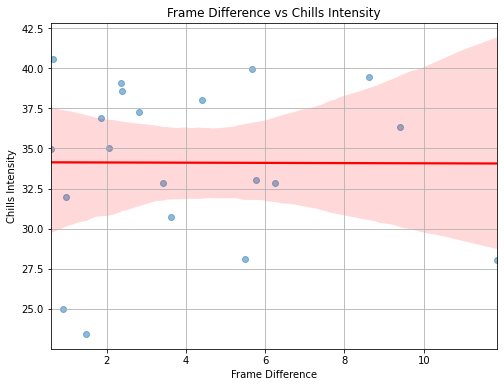

In [94]:
# Scatter plot with trend line
plt.figure(figsize=(8, 6))
sns.regplot(x=stimuli_videos['frame_difference'], y=stimuli_videos['chills_intensity'], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Frame Difference vs Chills Intensity")
plt.xlabel("Frame Difference")
plt.ylabel("Chills Intensity")
plt.grid()
plt.show()

In [95]:
stimuli_videos.columns

Index(['Stimulus_x', 'Description ', 'URL', 'video_id', 'video_filename',
       'frame_difference', 'color_distribution', 'average_brightness',
       'average_contrast', 'alt_stimulus', 'yes_count', 'chills_intensity'],
      dtype='object')

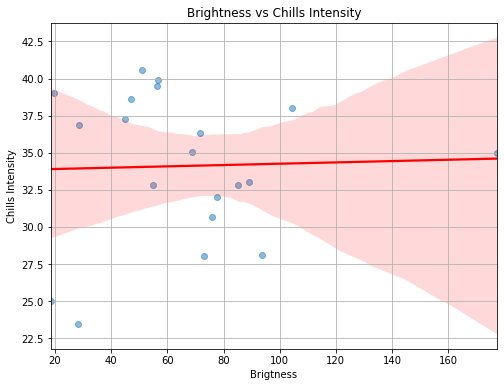

In [98]:
# Scatter plot with trend line
plt.figure(figsize=(8, 6))
sns.regplot(x=stimuli_videos['average_brightness'], y=stimuli_videos['chills_intensity'], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Brightness vs Chills Intensity")
plt.xlabel("Brigtness")
plt.ylabel("Chills Intensity")
plt.grid()
plt.show()

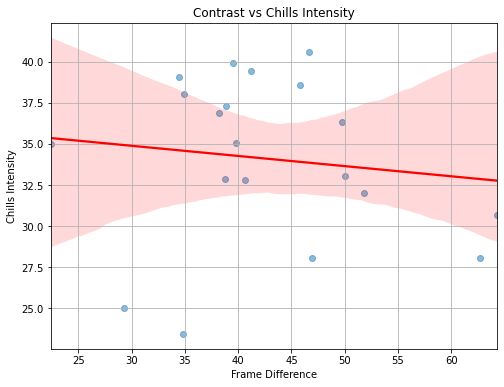

In [97]:
# Scatter plot with trend line
plt.figure(figsize=(8, 6))
sns.regplot(x=stimuli_videos['average_contrast'], y=stimuli_videos['chills_intensity'], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Contrast vs Chills Intensity")
plt.xlabel("Contrast")
plt.ylabel("Chills Intensity")
plt.grid()
plt.show()

## Model Fitting to Discover Feature Importance for Visual Features

2. Convert color distribution to a singular value if possible 
3. Create feature importance model
4. Create separate model with color distribution 

In [1]:
import pandas as pd 
import numpy as np

In [43]:
chills_db = pd.read_csv("ChillsDB.csv")
chills_video = chills_db[chills_db['Audio'] == 'Video'].copy()

In [44]:
chills_video['Chills_Yes'] = chills_video['Chills?'].map({'Yes': 1, 'No': 0})
result = chills_video.groupby('Stimulus')['Chills_Yes'].mean()

In [45]:
result

Stimulus
A Thing About Life                0.560000
Air France                        0.507246
Amelie                            0.414286
Aramaic Choir                     0.525641
Be Kind                           0.381579
Cloud Atlas                       0.405405
Dead Poets                        0.521127
Great Dictator                    0.528571
Hans Zimmer Time                  0.591549
Interstellar                      0.558824
Italy Balconies                   0.493151
Mr. Rogers Doc                    0.532468
Mr. Rogers Testimony              0.565789
Muhammad Ali                      0.551282
Perfect Planet                    0.527778
Remember the Titans               0.569620
Rocky                             0.613333
Thai Medicine                     0.576923
Think Too Much Feel Too Little    0.626667
Unsung Hero (Thai Insurance)      0.544118
Name: Chills_Yes, dtype: float64

In [46]:
result

Stimulus
A Thing About Life                0.560000
Air France                        0.507246
Amelie                            0.414286
Aramaic Choir                     0.525641
Be Kind                           0.381579
Cloud Atlas                       0.405405
Dead Poets                        0.521127
Great Dictator                    0.528571
Hans Zimmer Time                  0.591549
Interstellar                      0.558824
Italy Balconies                   0.493151
Mr. Rogers Doc                    0.532468
Mr. Rogers Testimony              0.565789
Muhammad Ali                      0.551282
Perfect Planet                    0.527778
Remember the Titans               0.569620
Rocky                             0.613333
Thai Medicine                     0.576923
Think Too Much Feel Too Little    0.626667
Unsung Hero (Thai Insurance)      0.544118
Name: Chills_Yes, dtype: float64

In [56]:
stimuli_videos = pd.read_csv('stimuli_videos', index_col = 0)

In [57]:
stimuli_videos

,Stimulus_x,Description,URL,video_id,video_filename,frame_difference,color_distribution,average_brightness,average_contrast,alt_stimulus,yes_count,chills_intensity
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2...",177.374737,22.377974,Air France,35.0,34.985507
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098...",18.381782,29.248181,Be Kind,29.0,25.013158
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000...",68.793390,39.830473,Interstellar,38.0,35.044118
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006...",51.094711,46.649189,Mr. Rogers Testimony,43.0,40.592105
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087...",34.377586,38.343040,NaN,NaN,NaN
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129...",28.155478,34.790598,Cloud Atlas,30.0,23.432432
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004...",85.039924,40.616199,A Thing About Life,42.0,32.813333
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180...",28.643520,38.152513,Remember the Titans,45.0,36.873418
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029...",73.064852,62.668641,Amelie,29.0,28.057143
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450...",47.044304,45.756505,Thai Medicine,45.0,38.602564


In [58]:
stimuli_videos = stimuli_videos.merge(result, left_on='alt_stimulus', right_on = 'Stimulus', how='left')

In [50]:
stimuli_videos

,Stimulus_x,Description,URL,video_id,video_filename,frame_difference,color_distribution,average_brightness,average_contrast,alt_stimulus,yes_count,chills_intensity,Chills_Yes
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2...",177.374737,22.377974,Air France,35.0,34.985507,0.507246
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098...",18.381782,29.248181,Be Kind,29.0,25.013158,0.381579
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000...",68.793390,39.830473,Interstellar,38.0,35.044118,0.558824
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006...",51.094711,46.649189,Mr. Rogers Testimony,43.0,40.592105,0.565789
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087...",34.377586,38.343040,NaN,NaN,NaN,NaN
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129...",28.155478,34.790598,Cloud Atlas,30.0,23.432432,0.405405
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004...",85.039924,40.616199,A Thing About Life,42.0,32.813333,0.560000
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180...",28.643520,38.152513,Remember the Titans,45.0,36.873418,0.569620
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029...",73.064852,62.668641,Amelie,29.0,28.057143,0.414286
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450...",47.044304,45.756505,Thai Medicine,45.0,38.602564,0.576923


In [64]:
# Function to extract summary stats
import ast 

# Function to extract summary stats
def extract_color_features(color_dict):
    features = {}
    for color in ['red_histogram', 'green_histogram', 'blue_histogram']:
        features[f'{color}_mean'] = np.mean(color_dict[color])
        features[f'{color}_std'] = np.std(color_dict[color])
        features[f'{color}_min'] = np.min(color_dict[color])
        features[f'{color}_max'] = np.max(color_dict[color])
    return features

df_features = stimuli_videos['color_distribution'].apply(lambda x: pd.Series(extract_color_features(x)))
stimuli_videos = pd.concat([stimuli_videos, df_features], axis=1).drop(columns=['color_distribution'])

In [65]:
stimuli_videos

,Stimulus_x,Description,URL,video_id,video_filename,frame_difference,average_brightness,average_contrast,alt_stimulus,yes_count,...,red_histogram_min,red_histogram_max,green_histogram_mean,green_histogram_std,green_histogram_min,green_histogram_max,blue_histogram_mean,blue_histogram_std,blue_histogram_min,blue_histogram_max
0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,177.374737,22.377974,Air France,35.0,...,3.653067e-06,0.015294,0.001302,0.002186,3.239294e-06,0.007619,0.001302,0.001576,2.977431e-06,0.005102
1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,18.381782,29.248181,Be Kind,29.0,...,1.087818e-05,0.065063,0.001302,0.004905,2.143374e-05,0.059040,0.001302,0.005084,4.450231e-06,0.064527
2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,68.793390,39.830473,Interstellar,38.0,...,4.774306e-08,0.026087,0.001302,0.002289,2.329282e-07,0.023277,0.001302,0.002334,1.707176e-07,0.024744
3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,51.094711,46.649189,Mr. Rogers Testimony,43.0,...,2.603927e-05,0.037849,0.001302,0.002162,3.094744e-06,0.025314,0.001302,0.001866,3.007146e-05,0.024481
4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,34.377586,38.343040,NaN,NaN,...,1.347367e-05,0.087210,0.001302,0.005611,1.090278e-05,0.086255,0.001302,0.005631,1.387008e-05,0.086120
5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,28.155478,34.790598,Cloud Atlas,30.0,...,1.558160e-06,0.134748,0.001302,0.009476,1.793837e-05,0.151445,0.001302,0.007505,1.050058e-05,0.117851
6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,85.039924,40.616199,A Thing About Life,42.0,...,6.202257e-05,0.016259,0.001302,0.001047,7.332610e-05,0.013109,0.001302,0.001080,1.256380e-04,0.012780
7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,28.643520,38.152513,Remember the Titans,45.0,...,1.446759e-09,0.165625,0.001302,0.010721,0.000000e+00,0.171361,0.001302,0.010466,0.000000e+00,0.167032
8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,73.064852,62.668641,Amelie,29.0,...,9.259259e-08,0.046247,0.001302,0.003351,1.994372e-04,0.039205,0.001302,0.003223,4.985822e-04,0.037617
9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,47.044304,45.756505,Thai Medicine,45.0,...,5.856416e-06,0.067963,0.001302,0.005115,7.534328e-06,0.068473,0.001302,0.004899,2.110411e-05,0.064349


**Testing for Feature Importance**

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
#import shap
from sklearn.feature_selection import mutual_info_regression
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [1]:
import shap

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [71]:
stimuli_videos.to_csv('stimuli_videos')

In [75]:
stimuli_videos.columns

Index(['Stimulus_x', 'Description ', 'URL', 'video_id', 'video_filename',
       'frame_difference', 'average_brightness', 'average_contrast',
       'alt_stimulus', 'yes_count', 'chills_intensity', 'Chills_Yes',
       'red_histogram_mean', 'red_histogram_std', 'red_histogram_min',
       'red_histogram_max', 'green_histogram_mean', 'green_histogram_std',
       'green_histogram_min', 'green_histogram_max', 'blue_histogram_mean',
       'blue_histogram_std', 'blue_histogram_min', 'blue_histogram_max'],
      dtype='object')

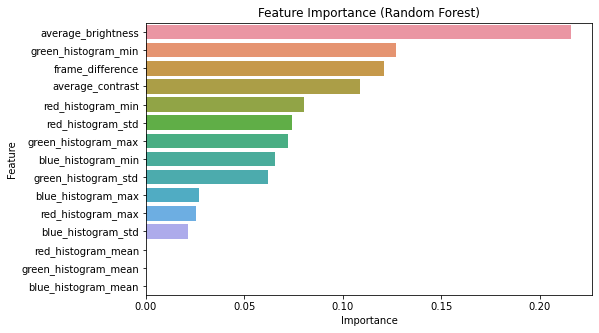

In [85]:
# Split into features and target
X = stimuli_videos.drop(columns=['Stimulus_x', 'Description ', 'URL', 'video_id',
                                'video_filename', 'alt_stimulus', 'yes_count', 'chills_intensity',
                                'Chills_Yes'])
y = stimuli_videos['Chills_Yes']

mask = y.notna()
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------
# 1. FEATURE IMPORTANCE ANALYSIS
# ---------------------------------

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [91]:
# ---------------------------------
# 2. SHAP VALUES FOR FEATURE IMPORTANCE & INTERACTIONS
# ---------------------------------
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

# SHAP interaction values (detects feature interactions)
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

NameError: name 'shap' is not defined

In [90]:
# Pairwise Mutual Information (Measures feature interactions)
def compute_mutual_info(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mi_scores})
    return mi_df.sort_values(by='Mutual_Info', ascending=False)

mi_df = compute_mutual_info(X, y)
print("Mutual Information Scores:\n", mi_df)

# Interaction between pairs using polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_train)
poly_features = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=X.columns)

interaction_model = LinearRegression()
interaction_model.fit(X_poly_df, y_train)

# Get coefficients
interaction_importance = pd.DataFrame({'Feature': poly_features, 'Coefficient': interaction_model.coef_})
interaction_importance = interaction_importance.sort_values(by='Coefficient', key=abs, ascending=False)

print("Top Feature Interactions:")
print(interaction_importance.head(10))

Mutual Information Scores:
                  Feature  Mutual_Info
14    blue_histogram_max     0.069763
9    green_histogram_min     0.068335
2       average_contrast     0.038828
1     average_brightness     0.017701
13    blue_histogram_min     0.016397
4      red_histogram_std     0.011299
0       frame_difference     0.003773
3     red_histogram_mean     0.000000
5      red_histogram_min     0.000000
6      red_histogram_max     0.000000
7   green_histogram_mean     0.000000
8    green_histogram_std     0.000000
10   green_histogram_max     0.000000
11   blue_histogram_mean     0.000000
12    blue_histogram_std     0.000000


AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names_out'

## Testing for Interactions with Other Features

In [2]:
stimuli_text = pd.read_csv("stimuli_text_video")

In [3]:
stimuli_text

,Unnamed: 0.1,Unnamed: 0,Stimulus_x,Description,URL,video_id,video_filename,frame_difference,color_distribution,average_brightness,average_contrast,alt_stimulus,yes_count,chills_intensity,transcript,music
0,0,0.0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,"{'red_histogram': [0.00016883680555555556, 8.2...",177.374737,22.377974,Air France,35.0,34.985507,NaN,True
1,1,1.0,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,"{'red_histogram': [0.06506255208333334, 0.0098...",18.381782,29.248181,Be Kind,29.0,25.013158,NaN,True
2,2,2.0,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,"{'red_histogram': [0.005921038773148148, 0.000...",68.793390,39.830473,Interstellar,38.0,35.044118,the wisest person I ever met in my life a thir...,False
3,3,3.0,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,"{'red_histogram': [0.037849343015214386, 0.006...",51.094711,46.649189,Mr. Rogers Testimony,43.0,40.592105,you can't connect the dots looking forward you...,False
4,4,4.0,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,"{'red_histogram': [0.028048857060185187, 0.087...",34.377586,38.343040,NaN,NaN,NaN,thank you life is your life [Music] don't let ...,False
5,5,5.0,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,"{'red_histogram': [0.13474766203703703, 0.0129...",28.155478,34.790598,Cloud Atlas,30.0,23.432432,[Verse 1]\nNow I've heard there was a secret c...,False
6,6,6.0,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,"{'red_histogram': [0.016258826678240742, 0.004...",85.039924,40.616199,A Thing About Life,42.0,32.813333,foreign [Music] essay written by Sigmund Freud...,False
7,7,7.0,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,"{'red_histogram': [0.16562535590277777, 0.0180...",28.643520,38.152513,Remember the Titans,45.0,36.873418,NaN,True
8,8,8.0,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,"{'red_histogram': [0.04624716145833333, 0.0029...",73.064852,62.668641,Amelie,29.0,28.057143,Look again at that dot. That's here. That's ho...,False
9,9,9.0,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,"{'red_histogram': [0.06796348691998107, 0.0450...",47.044304,45.756505,Thai Medicine,45.0,38.602564,NaN,True


In [9]:
audio_features = pd.read_csv("pca_video_audio_features.csv")

In [10]:
audio_features

,file,tempo,spectrogram_pca,mfcc_pca,chroma_pca
0,Air France,[80.35714286],"[-469.670284280409, 15.947745505262445, -30.62...","[-24.998340399908393, -63.71057156214729, 51.1...","[-8.984206281966065, -35.92753180648671, -78.1..."
1,Be Kind (Everything Everywhere All At Once),[127.84090909],"[17.90996071199449, -109.94511284638202, 206.7...","[-29.089213832240084, 24.56885946363409, 10.84...","[48.46432838283309, 26.296697935938194, -4.399..."
2,Interstellar with Hans Zimmer,[187.5],"[-605.4912467451104, 157.04123039186868, -73.3...","[-16.9284220764973, -73.55788992208414, -49.43...","[-94.82613503052231, -1.7749724667878126, 17.6..."
3,Mr Rogers Testimony,[117.1875],"[-59.07923225891001, -234.18238890450414, -13....","[-29.287463915742492, -11.077439644321835, 20....","[31.318022987533325, 36.78315666050343, -3.435..."
4,Hunger Games,[100.44642857],"[-510.9446174551375, 114.8058392328185, -66.95...","[-25.494231888997987, -34.84028816624317, -27....","[-4.124173870349597, -43.73664340247998, -25.5..."
5,Cloud Atlas,[140.625],"[173.74077272777038, -190.03853277038002, -0.8...","[-9.861669954726391, 13.101947958359238, 21.48...","[32.13367907120955, -2.9656684518348237, -14.3..."
6,A Thing About Life,[127.84090909],"[-38.140060203990146, -88.64919951903639, 20.1...","[12.390704144474174, 22.373629079838363, 24.19...","[-16.158611721284906, 59.2594006059516, 33.742..."
7,Remembering the Titans,[170.45454545],"[734.3941484962064, -521.5540340658101, -83.50...","[54.340393776683285, 72.69481226398364, -69.04...","[-16.799982168454136, 1.4632091942612098, -21...."
8,Amélie - Helping a Blind Man,[137.19512195],"[429.6722606181588, -213.16779238873954, 73.74...","[62.61953433206015, 1.867488644497888, -0.2844...","[19.19591899772692, 6.210816302279095, -11.252..."
9,Giving Is The Best Communication,[53.57142857],"[213.85382224218495, -119.85453487553532, -49....","[4.330863594667269, -9.955970306740532, -9.079...","[-36.19954957987578, -5.773193109122152, 20.79..."


In [12]:
audio_features.iloc[1]['mfcc_pca']

'[-29.089213832240084, 24.56885946363409, 10.842897875228797, 21.431411542792564, -20.60317349850656, -2.003977370303905, 23.929597555849803, 1.6785798818473345, 8.694777106144807, 2.7955314917638776]'

In [13]:
stimuli_videos = pd.read_csv("stimuli_videos")

In [14]:
stimuli_videos

,Unnamed: 0,Stimulus_x,Description,URL,video_id,video_filename,frame_difference,average_brightness,average_contrast,alt_stimulus,...,red_histogram_min,red_histogram_max,green_histogram_mean,green_histogram_std,green_histogram_min,green_histogram_max,blue_histogram_mean,blue_histogram_std,blue_histogram_min,blue_histogram_max
0,0,Air France,The beauty of human form in dance is celebrate...,https://youtu.be/yEKe5xrAsyo,yEKe5xrAsyo,yEKe5xrAsyo.mp4,0.588075,177.374737,22.377974,Air France,...,3.653067e-06,0.015294,0.001302,0.002186,3.239294e-06,0.007619,0.001302,0.001576,2.977431e-06,0.005102
1,1,Be Kind (Everything Everywhere All At Once),"In this sci-fi film, a man delivers an earnest...",https://youtu.be/hyQpXYFhL2A,hyQpXYFhL2A,hyQpXYFhL2A.mp4,0.892011,18.381782,29.248181,Be Kind,...,1.087818e-05,0.065063,0.001302,0.004905,2.143374e-05,0.059040,0.001302,0.005084,4.450231e-06,0.064527
2,2,Interstellar with Hans Zimmer,"In Earth's future, a global blight and Dust Bo...",https://youtu.be/n2ks3g5fySE,n2ks3g5fySE,n2ks3g5fySE.mp4,2.049571,68.793390,39.830473,Interstellar,...,4.774306e-08,0.026087,0.001302,0.002289,2.329282e-07,0.023277,0.001302,0.002334,1.707176e-07,0.024744
3,3,Mr Rogers Testimony,"In 1969, facing government budget cuts to publ...",https://youtu.be/iiFEiUe8k8U,iiFEiUe8k8U,iiFEiUe8k8U.mp4,0.640840,51.094711,46.649189,Mr. Rogers Testimony,...,2.603927e-05,0.037849,0.001302,0.002162,3.094744e-06,0.025314,0.001302,0.001866,3.007146e-05,0.024481
4,4,Hunger Games,"In a dystopian future, a young woman reluctant...",https://youtu.be/LY2BbmeAP6M,LY2BbmeAP6M,LY2BbmeAP6M.mp4,4.401803,34.377586,38.343040,NaN,...,1.347367e-05,0.087210,0.001302,0.005611,1.090278e-05,0.086255,0.001302,0.005631,1.387008e-05,0.086120
5,5,Cloud Atlas,In this scene from the science fiction film Cl...,https://youtu.be/tnXHFqw1ckk,tnXHFqw1ckk,tnXHFqw1ckk.mp4,1.469707,28.155478,34.790598,Cloud Atlas,...,1.558160e-06,0.134748,0.001302,0.009476,1.793837e-05,0.151445,0.001302,0.007505,1.050058e-05,0.117851
6,6,A Thing About Life,"This inspirational video, from Youtube creator...",https://youtu.be/5MveHH5k10I,5MveHH5k10I,5MveHH5k10I.mp4,6.253574,85.039924,40.616199,A Thing About Life,...,6.202257e-05,0.016259,0.001302,0.001047,7.332610e-05,0.013109,0.001302,0.001080,1.256380e-04,0.012780
7,7,Remembering the Titans,"After generations of segregation in Virginia, ...",https://youtu.be/RbWWQbMqKdQ,RbWWQbMqKdQ,RbWWQbMqKdQ.mp4,1.854575,28.643520,38.152513,Remember the Titans,...,1.446759e-09,0.165625,0.001302,0.010721,0.000000e+00,0.171361,0.001302,0.010466,0.000000e+00,0.167032
8,8,Amélie - Helping a Blind Man,After feeling the joy one gets from helping ot...,https://youtu.be/7BLhxyMyNOc,7BLhxyMyNOc,7BLhxyMyNOc.mp4,11.845170,73.064852,62.668641,Amelie,...,9.259259e-08,0.046247,0.001302,0.003351,1.994372e-04,0.039205,0.001302,0.003223,4.985822e-04,0.037617
9,9,Giving Is The Best Communication,“Giving is the best communication.” This short...,https://youtu.be/mn26zmFwUNk,mn26zmFwUNk,mn26zmFwUNk.mp4,2.382186,47.044304,45.756505,Thai Medicine,...,5.856416e-06,0.067963,0.001302,0.005115,7.534328e-06,0.068473,0.001302,0.004899,2.110411e-05,0.064349
